<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [4]:
!python --version

Python 3.9.16


In [5]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("../data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("../data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("../data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to /home/jm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Block Building

In [6]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking
)

/home/conda/miniconda3/envs/pyjedai-progressive/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking: 100%|██████████| 2152/2152 [00:00<00:00, 23405.31it/s]


In [8]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0929 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [9]:
from pyjedai.block_cleaning import BlockFiltering

In [10]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering: 100%|██████████| 3/3 [00:00<00:00, 71.63it/s]


# Comparison Cleaning


In [11]:
from pyjedai.block_cleaning import BlockPurging

In [12]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging: 100%|██████████| 6216/6216 [00:00<00:00, 471921.83it/s]


In [13]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 2491.0
Runtime: 0.0143 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      1.13% 
	Recall:        99.54%
	F1-score:       2.24%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1071
	False positives: 93348
	True negatives: 1064423
	False negatives: 5
	Total comparisons: 94419
─────────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 1.1343055952721381,
 'Recall %': 99.53531598513011,
 'F1 %': 2.2430493743127915,
 'True Positives': 1071,
 'False Positives': 93348,
 'True Negatives': 1064423,
 'False Negatives': 5}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [27]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM,
    WhooshPM
)

In [28]:
%%time
inorder_ltpm = LocalTopPM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

inorder_ltpm_pairs = inorder_ltpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', indexing='inorder', tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 1 s, sys: 3.4 ms, total: 1.01 s
Wall time: 1 s


In [29]:
%%time
reverse_ltpm = LocalTopPM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    number_of_nearest_neighbors=10,
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

reverse_ltpm_pairs = reverse_ltpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', indexing='reverse', tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.17 s


In [30]:
%%time
bilateral_ltpm = LocalTopPM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    number_of_nearest_neighbors=10,
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

bilateral_ltpm_pairs = bilateral_ltpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', indexing='bilateral', tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s


In [47]:
%%time
gtpm = GlobalTopPM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    number_of_nearest_neighbors=10,
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

bilateral_ltpm_pairs = bilateral_ltpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', indexing='inorder', tqdm_disable=True, emit_all_tps_stop=False)

TypeError: __init__() got an unexpected keyword argument 'w_scheme'

In [15]:
%%time
gpsnm = GlobalPSNM(
    weighting_scheme = 'ID',
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = gpsnm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

NameError: name 'GlobalPSNM' is not defined

In [16]:
%%time
lpsnm = LocalPSNM(
    weighting_scheme = 'ID',
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = lpsnm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

NameError: name 'LocalPSNM' is not defined

In [17]:
%%time
ennbpm = EmbeddingsNNBPM(
    language model = 'sminilm',
    similarity_search = 'faiss',
    similarity_function = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ennbpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

NameError: name 'EmbeddingsNNBPM' is not defined

In [18]:
%%time
rpm = RandomPM(
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

NameError: name 'RandomPM' is not defined

In [221]:
%%time
pesm = PESM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 5.28 s, sys: 7.93 ms, total: 5.29 s
Wall time: 5.29 s


In [225]:
%%time
whpm = WhooshPM(
    similarity_function='TF-IDF',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

whpm_graph = whpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

Applying TF-IDF Similarity Function
CPU times: user 7.47 s, sys: 35.9 ms, total: 7.51 s
Wall time: 7.55 s


In [31]:
matchers_data = []

# matchers_data.append(("Random", rpm))
# matchers_data.append(("Local Top", ltpm))
# matchers_data.append(("Global Top", gtpm))
# matchers_data.append(("GSN", gpsnm))
# matchers_data.append(("ES-BFS", pesm))
# matchers_data.append(("ENNBPM-HB", ennbpm))
# matchers_data.append(("WHOOSH-BFS", whpm))
matchers_data.append(("Inorder LTPM", inorder_ltpm))
matchers_data.append(("Reverse LTPM", reverse_ltpm))
matchers_data.append(("Bilateral LTPM", bilateral_ltpm))


TPS checked: None
TPS checked: None
TPS checked: None


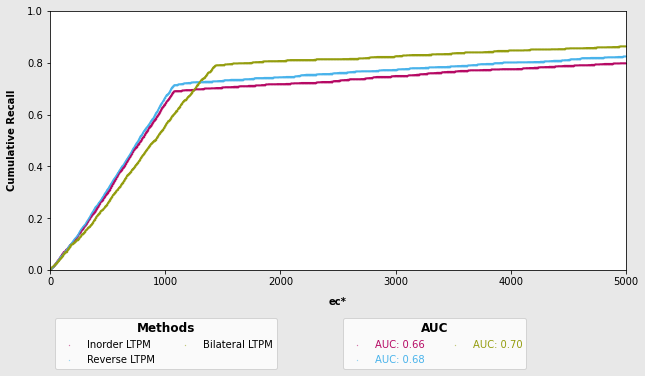

CPU times: user 138 ms, sys: 85 ms, total: 223 ms
Wall time: 103 ms


In [32]:
%%time
progressive_matchers_evaluator = Evaluation(data)
progressive_matchers_evaluator.evaluate_auc_roc(matchers_data = matchers_data, proportional = False)

In [15]:
# After supplying the progressive matchers to AUC ROC evaluation
# You can easily retrieve information about the method's performance using corresponding functions
# You can get the total number of emissions, the final cumulative recall and the normalized AUC

# Example for Entity Scheduling with BFS Method:
print(f'Total Emissions: {pesm.get_total_emissions()}')
print(f'Cumulative Recall: {pesm.get_cumulative_recall()}')
print(f'Normalized AUC: {pesm.get_normalized_auc()}')

NameError: name 'pesm' is not defined

In [18]:
print(f'Total Emissions: {ennbpm.get_total_emissions()}')
print(f'Cumulative Recall: {ennbpm.get_cumulative_recall()}')
print(f'Normalized AUC: {ennbpm.get_normalized_auc()}')

Total Emissions: 106443
Cumulative Recall: 1.0
Normalized AUC: 0.8425875763167529


In [172]:
print(f'Total Emissions: {ennbpm.get_total_emissions()}')
print(f'Cumulative Recall: {ennbpm.get_cumulative_recall()}')
print(f'Normalized AUC: {ennbpm.get_normalized_auc()}')

Total Emissions: 106117
Cumulative Recall: 0.9990706319702602
Normalized AUC: 0.8208217202276312


In [6]:
from pyjedai.workflow import ProgressiveWorkFlow

SyntaxError: invalid syntax (workflow.py, line 362)